In [75]:
# Descargamos las librerías
import librosa
import glob
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa.display import specshow

import scipy.stats as st
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import joblib

In [206]:
# Importamos los datos (descargados localmente)
zero_wavs = glob.glob('speechcommands/zero/*.wav')
one_wavs = glob.glob('speechcommands/one/*.wav')
two_wavs = glob.glob('speechcommands/two/*.wav')
three_wavs = glob.glob('speechcommands/three/*.wav')
four_wavs = glob.glob('speechcommands/four/*.wav')
five_wavs = glob.glob('speechcommands/five/*.wav')
six_wavs = glob.glob('speechcommands/six/*.wav')
seven_wavs = glob.glob('speechcommands/seven/*.wav')
eight_wavs = glob.glob('speechcommands/eight/*.wav')
nine_wavs = glob.glob('speechcommands/nine/*.wav')

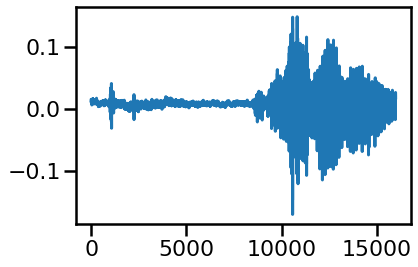

In [134]:
#Prueba para ver si están bien cargados los datos
x,sr = librosa.core.load(zero_wavs[2],sr=None)
plt.plot(x)
Audio(x,rate=sr)

### a) Extraer atributos a partir de los audios correspondientes a los digitos del 0 al 9. Utilizar el material suplementario dado durante la clase de presentación del TP.

In [12]:
def calculate_features(filename, n_mfcc=12,delta=True,deltadelta=True,energy=True, summary_fn = [np.mean, np.std], summary_names=['mean','std']):
  #Abro el archivo:
    x, sr = librosa.core.load(filename,sr=None)
  
  #Calculo MFCCs
    features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)
    feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
  #Calculo energia:
    if energy:
        energy = librosa.feature.rms(x)
        features = np.concatenate([features,energy])
        feat_names = feat_names + ['energy']
  #Aplico media y desvio estandar por defecto
    summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
    feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
  
  #Lo mismo con los delta
    if delta:
        deltafeatures = np.diff(features)
        summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])
        d_names = ['d{}'.format(name) for name in feat_names]
    else:
        d_names = []

  #Y con los delta de segundo orden
    if deltadelta:
        deltadeltafeatures = np.diff(features,n=2)
        summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
        dd_names = ['dd{}'.format(name) for name in feat_names]
    else:
        dd_names = []

    feat_names = feat_names + d_names + dd_names
  
    return summary_features, feat_names  

In [ ]:
#Extraemos las features y pasamos el dataset a un formato tabular 
df = pd.DataFrame()
wavs = [zero_wavs, one_wavs, two_wavs, three_wavs, four_wavs, five_wavs, 
        six_wavs, seven_wavs ,eight_wavs, nine_wavs ]

for wav in wavs:
    for i in range(len(wav)):
        feat, names = calculate_features(wav[i])
        df_aux = pd.DataFrame([feat], columns=names)
        name = wav[i]
        name = name[15:]
        df_aux['file'] = name
        target = name.split('/')[0]
        df_aux['target'] = target
        df = pd.concat([df, df_aux])
    display(df.head(2))
    df.to_csv('numbers.csv', index=False)
df

In [39]:
#Lo cargamos una vez generado
df = pd.read_csv('numbers.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df['target'] = df['target'].str.split('\\', expand=True)[0]

### b) Utilizar la división de datos provista en el dataset para entrenamiento, validación y evaluación de los modelos a desarrollar.

In [43]:
#Importamos los listados de validation y test
testing_list = pd.read_csv('speechcommands/testing_list.txt', sep=' ', 
                           names=['file_test'])
validation_list = pd.read_csv('speechcommands/validation_list.txt', sep=' ', 
                              names=['file_val'])

In [45]:
# Cambiamos el formato para que quede igual que en el df
testing_list['file_test'] = testing_list['file_test'].str.replace('/', '\\')
validation_list['file_val'] = validation_list['file_val'].str.replace('/', '\\')

In [44]:
#Creamos una columna con el set. Ponemos 'train' por default
df['set'] = 'train'

In [46]:
#Hacemos un merge para identificar los registros de test
df = df.merge(testing_list, left_on='file', right_on='file_test', how='left', suffixes=('', '_y'))
df['set'][df['file_test'].notna()] = 'test'
df.drop(columns='file_test', inplace=True)

c:\users\juan.miguel.ferraro\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
#Idem para registros de validación
df = df.merge(validation_list, left_on='file', right_on='file_val', how='left', suffixes=('', '_y'))
df['set'][df['file_val'].notna()] = 'validation'
df.drop(columns='file_val', inplace=True)

c:\users\juan.miguel.ferraro\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
#Separamos los datasets
train = df[df['set']=='train']
validation = df[df['set']=='validation']
test = df[df['set']=='test']

### d) Evaluar y comparar el rendimiento (performance) de los modelos. Se podrá elegir lamedida de rendimiento que se estime más adecuada. Deberá justificarse la elección. Reportar la matriz de confusión de alguno de los modelos.

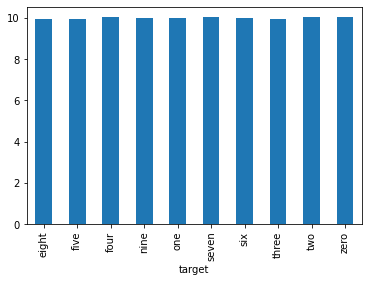

target
eight     9.94
five      9.96
four     10.02
nine      9.99
one      10.01
seven    10.04
six      10.01
three     9.96
two      10.03
zero     10.04
Name: mfcc_0_mean, dtype: float64

In [42]:
# Chequeamos que el dataset esté balanceado
distribucion = round(df.groupby('target').count().iloc[:,0] / df['target'].count() * 100, 2)
distribucion.plot.bar()
plt.show()
distribucion

Al estar balanceado el dataset, podemos elegir una métrica de accuracy para evaluar. No tenemos motivos para pensar que algún número tiene mayor "costo" en su error, por lo que no usaremos un indicador ponderado, sino que nos limitaremos al accuracy simple.

### c) Entrenar modelos de Naive Bayes, Random Forest y Gradient Boosting Machines para predecir a partir de los atributos acústicos el dígito pronunciado.

In [51]:
# Separamos train y test
train = df[df['set']!='test']
test = df[df['set']=='test']

In [52]:
# Usando redefinedSplit le indicamos los índices de train de de validation
my_test_fold = np.where(train['set']=='validation', 0,-1)
ps = PredefinedSplit(test_fold=my_test_fold)

In [53]:
# Ahora separamos X de y, sacando las variables que no corresponden al modelado
X_train = train.drop(columns=['set', 'file', 'target'])
y_train = train['target']
X_test = test.drop(columns=['set', 'file', 'target'])
y_test = test['target']

In [22]:
# Definimos los modelos
models = [GaussianNB(),
          RandomForestClassifier(class_weight='balanced'),
          GradientBoostingClassifier()]

In [23]:
# Seteamos el espacio de hiperparámetros
params = [{},
          {'n_estimators': st.randint(50,200), 
           'max_features': st.randint(10,50), 
           'max_depth': st.randint(5,100), 
           'max_depth': st.randint(5,100)
          },
          {'n_estimators':range(20, 200, 5), 
           'max_depth':range(1,7), 
           'learning_rate':np.arange(0,1,0.001)
          }]

In [ ]:
# Hacemos el Random search
all_models = []
i = 0
for i in range(len(models)):
    rs = RandomizedSearchCV(models[i], params[i], n_iter = 30, scoring='accuracy', verbose= 1, n_jobs=-1, cv=ps, 
                            random_state=42)
    print (rs)
    fit = rs.fit(X_train, y_train)
    all_models.append(fit)

In [219]:
# Guardamos los modelos por si las dudas
joblib.dump(all_models[0], './Modelos/GNB.sav')
joblib.dump(all_models[1], './Modelos/RF.sav')
joblib.dump(all_models[2], './Modelos/GB.sav')

['./Modelos/GB.sav']

In [57]:
# Los cargamos
all_models = []
all_models.append(joblib.load('./Modelos/GNB.sav'))
all_models.append(joblib.load('./Modelos/RF.sav'))
all_models.append(joblib.load('./Modelos/GB.sav'))

Mejor Modelo:  GaussianNB()
Val Accuracy:  0.5368885324779471
Test Accuracy:  0.5313479623824452


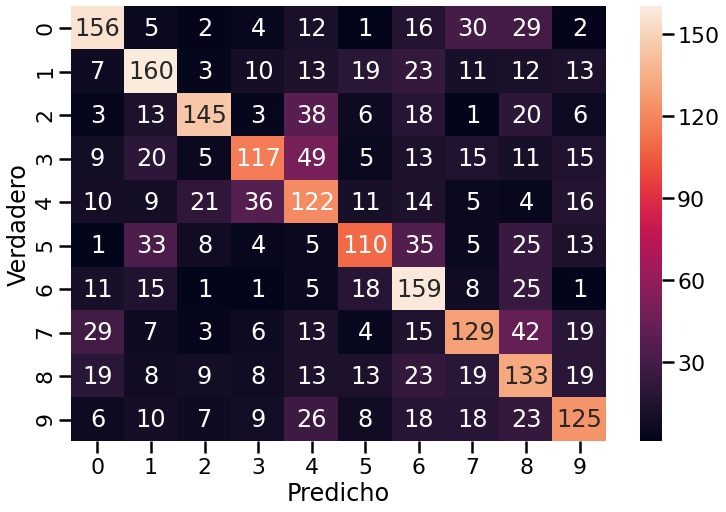

Clasification Report:
                precision    recall  f1-score   support

       eight       0.62      0.61      0.61       257
        five       0.57      0.59      0.58       271
        four       0.71      0.57      0.63       253
        nine       0.59      0.45      0.51       259
         one       0.41      0.49      0.45       248
       seven       0.56      0.46      0.51       239
         six       0.48      0.65      0.55       244
       three       0.54      0.48      0.51       267
         two       0.41      0.50      0.45       264
        zero       0.55      0.50      0.52       250

    accuracy                           0.53      2552
   macro avg       0.54      0.53      0.53      2552
weighted avg       0.54      0.53      0.53      2552

Mejor Modelo:  RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=12,
                       n_estimators=199)
Val Accuracy:  0.6960705693664796
Test Accuracy:  0.6829937304075235


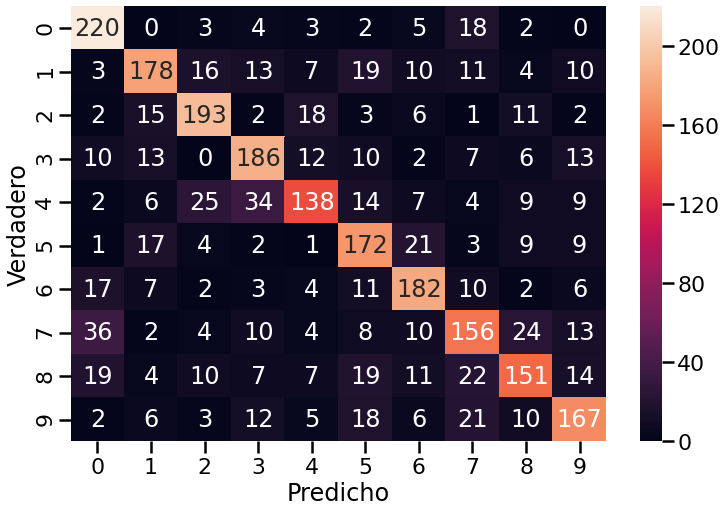

Clasification Report:
                precision    recall  f1-score   support

       eight       0.71      0.86      0.77       257
        five       0.72      0.66      0.69       271
        four       0.74      0.76      0.75       253
        nine       0.68      0.72      0.70       259
         one       0.69      0.56      0.62       248
       seven       0.62      0.72      0.67       239
         six       0.70      0.75      0.72       244
       three       0.62      0.58      0.60       267
         two       0.66      0.57      0.61       264
        zero       0.69      0.67      0.68       250

    accuracy                           0.68      2552
   macro avg       0.68      0.68      0.68      2552
weighted avg       0.68      0.68      0.68      2552

Mejor Modelo:  GradientBoostingClassifier(learning_rate=0.554, max_depth=6, n_estimators=195)
Val Accuracy:  0.7429831595829992
Test Accuracy:  0.7445141065830722


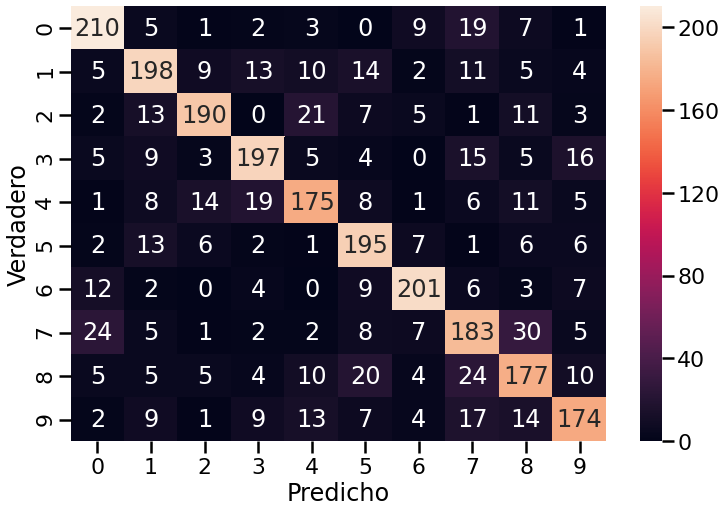

Clasification Report:
                precision    recall  f1-score   support

       eight       0.78      0.82      0.80       257
        five       0.74      0.73      0.74       271
        four       0.83      0.75      0.79       253
        nine       0.78      0.76      0.77       259
         one       0.73      0.71      0.72       248
       seven       0.72      0.82      0.76       239
         six       0.84      0.82      0.83       244
       three       0.65      0.69      0.67       267
         two       0.66      0.67      0.66       264
        zero       0.75      0.70      0.72       250

    accuracy                           0.74      2552
   macro avg       0.75      0.75      0.75      2552
weighted avg       0.75      0.74      0.74      2552



In [58]:
# Ploteamos las matrices de confusión y algunas métricas de los modelos
for i in all_models:
    print ("Mejor Modelo: ",i.best_estimator_)
    print ("Val Accuracy: ",i.best_score_)
    y_pred = i.predict(X_test)
    print ("Test Accuracy: ",accuracy_score(y_test, y_pred))
    plt.figure(figsize=(12,8))
    sns.set_context('poster')
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='g')
    plt.xlabel('Predicho')
    plt.ylabel('Verdadero')
    plt.show()
    print ("Clasification Report:\n ",classification_report(y_test,y_pred))

### e) Analizar los errores cometidos por los modelos.

Podemos observar a través de las matrices de confusión de los distintos modelos que los números que más le está costando a los mismos predecir son el 4, el 7, el 8 y el 9. En el primero observamos que suele confundirlo con el 3, creemos que se debe a la similaridad de los sonidos de la "f" y la "th" que confunde al algoritmo. Algo similar ocurre entre el 0 y el 7, donde parece confundir la "z" con la "s". Entre el 7 y el 8 parece haber también mucha confusion cruzada, quizás por el sonido de la "e" al principio del número. En el 9 parece no haber un número tan definido en el error (en la matriz del GB por ejemplo no supera ninguno los 20 errores), aunque sí hay algunos errores con el 7 y el 8, que ya vimos presentan similaridad entre los mismos.

Vamos a ver de escuchar los mayores errores a ver qué tienen para decir:

In [98]:
# El modelo ordena las clases como quiere, tenemos que usar ese orden
targets = all_models[2].classes_
targets

array(['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three',
       'two', 'zero'], dtype=object)

In [99]:
# Creamos el score asignado para cada numero
for i in range(len(targets)):
    test[f'prob_{targets[i]}'] = y_pred_proba[:,i]
test['prediction'] = y_pred

c:\users\juan.miguel.ferraro\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\juan.miguel.ferraro\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [140]:
# Buscamos los mayores errores: error con score = 1
mistakes = test[test['target'] != test['prediction']]
mistakes['biggest_errors']=mistakes.iloc[:,81:91].max(axis=1)
biggest = mistakes[mistakes['biggest_errors'] == 1].iloc[:,78:]
biggest

c:\users\juan.miguel.ferraro\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,file,target,set,prob_zero,prob_one,prob_two,prob_three,prob_four,prob_five,prob_six,prob_seven,prob_eight,prob_nine,prediction,biggest_errors
6013,two\8fe52b97_nohash_0.wav,two,test,8.766512e-26,2.000432e-29,6.484141e-26,8.425711e-27,5.122459e-31,6.377604e-30,1.040351e-29,1.000000e+00,3.094256e-31,2.543507e-28,seven,1.0
11072,four\af8b2f2c_nohash_1.wav,four,test,2.286489e-23,3.185580e-20,4.018850e-19,1.000000e+00,1.631131e-15,6.634740e-23,2.812393e-22,9.766134e-19,6.196545e-23,3.041603e-24,three,1.0
12602,five\5744b6a7_nohash_0.wav,five,test,2.942703e-150,6.060608e-149,2.881352e-146,1.816624e-150,5.354886e-148,6.066936e-143,1.810761e-149,1.000000e+00,2.181516e-147,2.534205e-150,seven,1.0
13523,five\b83c1acf_nohash_2.wav,five,test,1.705481e-22,8.539384e-18,2.481898e-18,1.000000e+00,1.611990e-20,1.611818e-20,1.127340e-19,2.423726e-21,3.861828e-18,5.143568e-22,three,1.0
14453,six\1cb788bc_nohash_0.wav,six,test,1.000000e+00,2.055991e-30,2.420757e-27,6.028502e-29,7.637056e-32,1.436289e-30,2.948099e-25,3.150164e-31,9.619845e-32,7.893660e-30,zero,1.0
18372,seven\c22d3f18_nohash_2.wav,seven,test,1.000000e+00,1.103671e-29,2.108651e-31,5.842001e-27,1.526792e-30,2.515321e-31,3.390024e-26,2.611135e-29,1.662723e-27,1.943527e-29,zero,1.0
20643,eight\b97c9f77_nohash_2.wav,eight,test,2.062642e-54,1.343474e-51,3.372912e-53,2.520919e-49,3.908189e-55,1.912851e-48,1.000000e+00,3.496139e-54,8.016418e-44,1.681455e-51,six,1.0


In [145]:
# Escuchamos los audios con mayores errores
audios = [glob.glob('speechcommands/two/8fe52b97_nohash_0.wav')[0], 
             glob.glob('speechcommands/four/af8b2f2c_nohash_1.wav')[0], 
             glob.glob('speechcommands/five/5744b6a7_nohash_0.wav')[0],
             glob.glob('speechcommands/five/b83c1acf_nohash_2.wav')[0], 
             glob.glob('speechcommands/six/1cb788bc_nohash_0.wav')[0], 
             glob.glob('speechcommands/seven/c22d3f18_nohash_2.wav')[0], 
             glob.glob('speechcommands/eight/b97c9f77_nohash_2.wav')[0]
         ]

target = biggest['target'].to_list()
prediction = biggest['prediction'].to_list()


for i in range(len(audios)):
    x,sr = librosa.core.load(audios[i],sr=None)
    #plt.plot(x)
    print('Target: ', target[i], 'Predicted: ', prediction[i])
    display(Audio(x,rate=sr))
    #plt.show()
#error = glob.glob('speechcommands/two/8fe52b97_nohash_0.wav')[0]
#errores.append(error)
#audios

Target:  two Predicted:  seven


Target:  four Predicted:  three


Target:  five Predicted:  seven


Target:  five Predicted:  three


Target:  six Predicted:  zero


Target:  seven Predicted:  zero


Target:  eight Predicted:  six


En los primeros audios parece haber ruido ambiente que hace fallar al modelo. En los últimos cuatro es más notable el motivo del error: están mal grabado, o están cortados, o no se entiende qué número quiso decir.

### f) Evaluar el impacto en el rendimiento de agregar distintos niveles de ruido en los audios de evaluación. Utilizar como señales de ruido:
#####       i) Ruido gaussiano.

In [196]:
import numpy as np

# Pruebas para determinar un nivel aceptable de ruido
t = np.linspace(0,1,44100)
audio, sr = librosa.core.load(zero_wavs[2],sr=None)
ruido = np.random.normal(size=audio.shape)
senal = 0.005 * ruido + audio

In [197]:
display(Audio(audio,rate=sr))
display(Audio(ruido,rate=sr))
display(Audio(senal,rate=sr))

In [212]:
def calculate_features_gaussian(filename, n_mfcc=12,delta=True,deltadelta=True,energy=True, summary_fn = [np.mean, np.std], summary_names=['mean','std']):
  #Abro el archivo:
    x, sr = librosa.core.load(filename,sr=None)
  
  #Agrego ruido gaussiano
    t = np.linspace(0,1,44100)
    ruido = np.random.normal(size=x.shape)
    x = 0.005 * ruido + x

  #Calculo MFCCs
    features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)
    feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
  #Calculo energia:
    if energy:
        energy = librosa.feature.rms(x)
        features = np.concatenate([features,energy])
        feat_names = feat_names + ['energy']
  #Aplico media y desvio estandar por defecto
    summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
    feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
  
  #Lo mismo con los delta
    if delta:
        deltafeatures = np.diff(features)
        summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])
        d_names = ['d{}'.format(name) for name in feat_names]
    else:
        d_names = []

  #Y con los delta de segundo orden
    if deltadelta:
        deltadeltafeatures = np.diff(features,n=2)
        summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
        dd_names = ['dd{}'.format(name) for name in feat_names]
    else:
        dd_names = []

    feat_names = feat_names + d_names + dd_names
  
    return summary_features, feat_names  

In [223]:
#Extraemos las features y pasamos el dataset a un formato tabular 
df_gaussian = pd.DataFrame()
wavs = [zero_wavs, one_wavs, two_wavs, three_wavs, four_wavs, five_wavs, 
        six_wavs, seven_wavs ,eight_wavs, nine_wavs ]

for wav in wavs:
    for i in range(len(wav)):
        feat, names = calculate_features_gaussian(wav[i])
        df_aux = pd.DataFrame([feat], columns=names)
        name = wav[i]
        name = name[15:]
        df_aux['file'] = name
        target = name.split('\\')[0]
        df_aux['target'] = target
        df_gaussian = pd.concat([df_gaussian, df_aux])
    display(df_gaussian.tail(2))
    df_gaussian.to_csv('numbers_gaussian.csv', index=False)
df_gaussian.sample(5)

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-275.829156,15.676923,-0.962080,1.704717,1.317117,-0.869050,-0.235791,-2.467961,0.218007,2.228908,-0.834942,-1.893661,0.011792,42.760785,26.218313,15.375841,9.813829,5.900062,6.666465,5.299970,7.100648,3.409416,4.270172,4.298378,4.599601,0.009550,0.234361,0.347507,0.242836,0.263198,0.011833,0.023719,0.029484,0.252073,0.098376,0.028201,0.12625,0.069706,-0.000001,15.621306,9.220617,10.212656,6.102101,4.043270,6.378159,5.362289,4.014374,2.999666,3.507162,3.520240,3.359253,0.002853,-0.758092,-0.244440,0.028762,-0.019495,-0.031362,-0.257860,0.016086,0.011837,0.023150,0.012715,-0.201459,-0.168523,1.532698e-06,11.938742,8.173563,10.858690,6.413372,5.250712,7.672330,6.766388,5.365015,4.202104,4.316247,4.474565,4.451854,0.001474,nine\0132a06d_nohash_4.wav,nine
0,-239.794287,47.653209,12.340364,-0.423801,-4.539865,0.170981,-5.319336,-11.113331,-3.229685,-1.878982,-2.154633,-1.428215,0.070634,74.226500,58.414154,18.921245,13.970644,13.619958,6.282884,11.607079,16.063254,8.506812,11.653213,9.223831,4.906908,0.085146,-0.204513,-0.037516,-0.166702,-0.135289,-0.059877,-0.021106,-0.043483,-0.035388,0.020398,-0.043575,-0.02473,-0.208899,-0.000009,21.751947,18.467689,12.088679,8.976466,7.061163,5.642447,7.009795,5.632293,6.355560,7.939255,6.870171,4.565252,0.023534,-0.373361,-0.025114,-0.153376,-0.124112,0.072206,-0.015985,0.013887,0.018383,-0.072722,-0.262026,-0.109268,0.076131,-7.489482e-07,16.768166,16.443089,12.989623,10.745861,7.849727,7.017963,7.990647,5.903093,7.478486,7.999593,8.082394,6.791985,0.014940,nine\0137b3f4_nohash_0.wav,nine


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-275.829156,15.676923,-0.962080,1.704717,1.317117,-0.869050,-0.235791,-2.467961,0.218007,2.228908,-0.834942,-1.893661,0.011792,42.760785,26.218313,15.375841,9.813829,5.900062,6.666465,5.299970,7.100648,3.409416,4.270172,4.298378,4.599601,0.009550,0.234361,0.347507,0.242836,0.263198,0.011833,0.023719,0.029484,0.252073,0.098376,0.028201,0.12625,0.069706,-0.000001,15.621306,9.220617,10.212656,6.102101,4.043270,6.378159,5.362289,4.014374,2.999666,3.507162,3.520240,3.359253,0.002853,-0.758092,-0.244440,0.028762,-0.019495,-0.031362,-0.257860,0.016086,0.011837,0.023150,0.012715,-0.201459,-0.168523,1.532698e-06,11.938742,8.173563,10.858690,6.413372,5.250712,7.672330,6.766388,5.365015,4.202104,4.316247,4.474565,4.451854,0.001474,nine\0132a06d_nohash_4.wav,nine
0,-239.794287,47.653209,12.340364,-0.423801,-4.539865,0.170981,-5.319336,-11.113331,-3.229685,-1.878982,-2.154633,-1.428215,0.070634,74.226500,58.414154,18.921245,13.970644,13.619958,6.282884,11.607079,16.063254,8.506812,11.653213,9.223831,4.906908,0.085146,-0.204513,-0.037516,-0.166702,-0.135289,-0.059877,-0.021106,-0.043483,-0.035388,0.020398,-0.043575,-0.02473,-0.208899,-0.000009,21.751947,18.467689,12.088679,8.976466,7.061163,5.642447,7.009795,5.632293,6.355560,7.939255,6.870171,4.565252,0.023534,-0.373361,-0.025114,-0.153376,-0.124112,0.072206,-0.015985,0.013887,0.018383,-0.072722,-0.262026,-0.109268,0.076131,-7.489482e-07,16.768166,16.443089,12.989623,10.745861,7.849727,7.017963,7.990647,5.903093,7.478486,7.999593,8.082394,6.791985,0.014940,nine\0137b3f4_nohash_0.wav,nine


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-275.829156,15.676923,-0.962080,1.704717,1.317117,-0.869050,-0.235791,-2.467961,0.218007,2.228908,-0.834942,-1.893661,0.011792,42.760785,26.218313,15.375841,9.813829,5.900062,6.666465,5.299970,7.100648,3.409416,4.270172,4.298378,4.599601,0.009550,0.234361,0.347507,0.242836,0.263198,0.011833,0.023719,0.029484,0.252073,0.098376,0.028201,0.12625,0.069706,-0.000001,15.621306,9.220617,10.212656,6.102101,4.043270,6.378159,5.362289,4.014374,2.999666,3.507162,3.520240,3.359253,0.002853,-0.758092,-0.244440,0.028762,-0.019495,-0.031362,-0.257860,0.016086,0.011837,0.023150,0.012715,-0.201459,-0.168523,1.532698e-06,11.938742,8.173563,10.858690,6.413372,5.250712,7.672330,6.766388,5.365015,4.202104,4.316247,4.474565,4.451854,0.001474,nine\0132a06d_nohash_4.wav,nine
0,-239.794287,47.653209,12.340364,-0.423801,-4.539865,0.170981,-5.319336,-11.113331,-3.229685,-1.878982,-2.154633,-1.428215,0.070634,74.226500,58.414154,18.921245,13.970644,13.619958,6.282884,11.607079,16.063254,8.506812,11.653213,9.223831,4.906908,0.085146,-0.204513,-0.037516,-0.166702,-0.135289,-0.059877,-0.021106,-0.043483,-0.035388,0.020398,-0.043575,-0.02473,-0.208899,-0.000009,21.751947,18.467689,12.088679,8.976466,7.061163,5.642447,7.009795,5.632293,6.355560,7.939255,6.870171,4.565252,0.023534,-0.373361,-0.025114,-0.153376,-0.124112,0.072206,-0.015985,0.013887,0.018383,-0.072722,-0.262026,-0.109268,0.076131,-7.489482e-07,16.768166,16.443089,12.989623,10.745861,7.849727,7.017963,7.990647,5.903093,7.478486,7.999593,8.082394,6.791985,0.014940,nine\0137b3f4_nohash_0.wav,nine


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-275.829156,15.676923,-0.962080,1.704717,1.317117,-0.869050,-0.235791,-2.467961,0.218007,2.228908,-0.834942,-1.893661,0.011792,42.760785,26.218313,15.375841,9.813829,5.900062,6.666465,5.299970,7.100648,3.409416,4.270172,4.298378,4.599601,0.009550,0.234361,0.347507,0.242836,0.263198,0.011833,0.023719,0.029484,0.252073,0.098376,0.028201,0.12625,0.069706,-0.000001,15.621306,9.220617,10.212656,6.102101,4.043270,6.378159,5.362289,4.014374,2.999666,3.507162,3.520240,3.359253,0.002853,-0.758092,-0.244440,0.028762,-0.019495,-0.031362,-0.257860,0.016086,0.011837,0.023150,0.012715,-0.201459,-0.168523,1.532698e-06,11.938742,8.173563,10.858690,6.413372,5.250712,7.672330,6.766388,5.365015,4.202104,4.316247,4.474565,4.451854,0.001474,nine\0132a06d_nohash_4.wav,nine
0,-239.794287,47.653209,12.340364,-0.423801,-4.539865,0.170981,-5.319336,-11.113331,-3.229685,-1.878982,-2.154633,-1.428215,0.070634,74.226500,58.414154,18.921245,13.970644,13.619958,6.282884,11.607079,16.063254,8.506812,11.653213,9.223831,4.906908,0.085146,-0.204513,-0.037516,-0.166702,-0.135289,-0.059877,-0.021106,-0.043483,-0.035388,0.020398,-0.043575,-0.02473,-0.208899,-0.000009,21.751947,18.467689,12.088679,8.976466,7.061163,5.642447,7.009795,5.632293,6.355560,7.939255,6.870171,4.565252,0.023534,-0.373361,-0.025114,-0.153376,-0.124112,0.072206,-0.015985,0.013887,0.018383,-0.072722,-0.262026,-0.109268,0.076131,-7.489482e-07,16.768166,16.443089,12.989623,10.745861,7.849727,7.017963,7.990647,5.903093,7.478486,7.999593,8.082394,6.791985,0.014940,nine\0137b3f4_nohash_0.wav,nine


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-275.829156,15.676923,-0.962080,1.704717,1.317117,-0.869050,-0.235791,-2.467961,0.218007,2.228908,-0.834942,-1.893661,0.011792,42.760785,26.218313,15.375841,9.813829,5.900062,6.666465,5.299970,7.100648,3.409416,4.270172,4.298378,4.599601,0.009550,0.234361,0.347507,0.242836,0.263198,0.011833,0.023719,0.029484,0.252073,0.098376,0.028201,0.12625,0.069706,-0.000001,15.621306,9.220617,10.212656,6.102101,4.043270,6.378159,5.362289,4.014374,2.999666,3.507162,3.520240,3.359253,0.002853,-0.758092,-0.244440,0.028762,-0.019495,-0.031362,-0.257860,0.016086,0.011837,0.023150,0.012715,-0.201459,-0.168523,1.532698e-06,11.938742,8.173563,10.858690,6.413372,5.250712,7.672330,6.766388,5.365015,4.202104,4.316247,4.474565,4.451854,0.001474,nine\0132a06d_nohash_4.wav,nine
0,-239.794287,47.653209,12.340364,-0.423801,-4.539865,0.170981,-5.319336,-11.113331,-3.229685,-1.878982,-2.154633,-1.428215,0.070634,74.226500,58.414154,18.921245,13.970644,13.619958,6.282884,11.607079,16.063254,8.506812,11.653213,9.223831,4.906908,0.085146,-0.204513,-0.037516,-0.166702,-0.135289,-0.059877,-0.021106,-0.043483,-0.035388,0.020398,-0.043575,-0.02473,-0.208899,-0.000009,21.751947,18.467689,12.088679,8.976466,7.061163,5.642447,7.009795,5.632293,6.355560,7.939255,6.870171,4.565252,0.023534,-0.373361,-0.025114,-0.153376,-0.124112,0.072206,-0.015985,0.013887,0.018383,-0.072722,-0.262026,-0.109268,0.076131,-7.489482e-07,16.768166,16.443089,12.989623,10.745861,7.849727,7.017963,7.990647,5.903093,7.478486,7.999593,8.082394,6.791985,0.014940,nine\0137b3f4_nohash_0.wav,nine


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-275.829156,15.676923,-0.962080,1.704717,1.317117,-0.869050,-0.235791,-2.467961,0.218007,2.228908,-0.834942,-1.893661,0.011792,42.760785,26.218313,15.375841,9.813829,5.900062,6.666465,5.299970,7.100648,3.409416,4.270172,4.298378,4.599601,0.009550,0.234361,0.347507,0.242836,0.263198,0.011833,0.023719,0.029484,0.252073,0.098376,0.028201,0.12625,0.069706,-0.000001,15.621306,9.220617,10.212656,6.102101,4.043270,6.378159,5.362289,4.014374,2.999666,3.507162,3.520240,3.359253,0.002853,-0.758092,-0.244440,0.028762,-0.019495,-0.031362,-0.257860,0.016086,0.011837,0.023150,0.012715,-0.201459,-0.168523,1.532698e-06,11.938742,8.173563,10.858690,6.413372,5.250712,7.672330,6.766388,5.365015,4.202104,4.316247,4.474565,4.451854,0.001474,nine\0132a06d_nohash_4.wav,nine
0,-239.794287,47.653209,12.340364,-0.423801,-4.539865,0.170981,-5.319336,-11.113331,-3.229685,-1.878982,-2.154633,-1.428215,0.070634,74.226500,58.414154,18.921245,13.970644,13.619958,6.282884,11.607079,16.063254,8.506812,11.653213,9.223831,4.906908,0.085146,-0.204513,-0.037516,-0.166702,-0.135289,-0.059877,-0.021106,-0.043483,-0.035388,0.020398,-0.043575,-0.02473,-0.208899,-0.000009,21.751947,18.467689,12.088679,8.976466,7.061163,5.642447,7.009795,5.632293,6.355560,7.939255,6.870171,4.565252,0.023534,-0.373361,-0.025114,-0.153376,-0.124112,0.072206,-0.015985,0.013887,0.018383,-0.072722,-0.262026,-0.109268,0.076131,-7.489482e-07,16.768166,16.443089,12.989623,10.745861,7.849727,7.017963,7.990647,5.903093,7.478486,7.999593,8.082394,6.791985,0.014940,nine\0137b3f4_nohash_0.wav,nine


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-275.829156,15.676923,-0.962080,1.704717,1.317117,-0.869050,-0.235791,-2.467961,0.218007,2.228908,-0.834942,-1.893661,0.011792,42.760785,26.218313,15.375841,9.813829,5.900062,6.666465,5.299970,7.100648,3.409416,4.270172,4.298378,4.599601,0.009550,0.234361,0.347507,0.242836,0.263198,0.011833,0.023719,0.029484,0.252073,0.098376,0.028201,0.12625,0.069706,-0.000001,15.621306,9.220617,10.212656,6.102101,4.043270,6.378159,5.362289,4.014374,2.999666,3.507162,3.520240,3.359253,0.002853,-0.758092,-0.244440,0.028762,-0.019495,-0.031362,-0.257860,0.016086,0.011837,0.023150,0.012715,-0.201459,-0.168523,1.532698e-06,11.938742,8.173563,10.858690,6.413372,5.250712,7.672330,6.766388,5.365015,4.202104,4.316247,4.474565,4.451854,0.001474,nine\0132a06d_nohash_4.wav,nine
0,-239.794287,47.653209,12.340364,-0.423801,-4.539865,0.170981,-5.319336,-11.113331,-3.229685,-1.878982,-2.154633,-1.428215,0.070634,74.226500,58.414154,18.921245,13.970644,13.619958,6.282884,11.607079,16.063254,8.506812,11.653213,9.223831,4.906908,0.085146,-0.204513,-0.037516,-0.166702,-0.135289,-0.059877,-0.021106,-0.043483,-0.035388,0.020398,-0.043575,-0.02473,-0.208899,-0.000009,21.751947,18.467689,12.088679,8.976466,7.061163,5.642447,7.009795,5.632293,6.355560,7.939255,6.870171,4.565252,0.023534,-0.373361,-0.025114,-0.153376,-0.124112,0.072206,-0.015985,0.013887,0.018383,-0.072722,-0.262026,-0.109268,0.076131,-7.489482e-07,16.768166,16.443089,12.989623,10.745861,7.849727,7.017963,7.990647,5.903093,7.478486,7.999593,8.082394,6.791985,0.014940,nine\0137b3f4_nohash_0.wav,nine


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-275.829156,15.676923,-0.962080,1.704717,1.317117,-0.869050,-0.235791,-2.467961,0.218007,2.228908,-0.834942,-1.893661,0.011792,42.760785,26.218313,15.375841,9.813829,5.900062,6.666465,5.299970,7.100648,3.409416,4.270172,4.298378,4.599601,0.009550,0.234361,0.347507,0.242836,0.263198,0.011833,0.023719,0.029484,0.252073,0.098376,0.028201,0.12625,0.069706,-0.000001,15.621306,9.220617,10.212656,6.102101,4.043270,6.378159,5.362289,4.014374,2.999666,3.507162,3.520240,3.359253,0.002853,-0.758092,-0.244440,0.028762,-0.019495,-0.031362,-0.257860,0.016086,0.011837,0.023150,0.012715,-0.201459,-0.168523,1.532698e-06,11.938742,8.173563,10.858690,6.413372,5.250712,7.672330,6.766388,5.365015,4.202104,4.316247,4.474565,4.451854,0.001474,nine\0132a06d_nohash_4.wav,nine
0,-239.794287,47.653209,12.340364,-0.423801,-4.539865,0.170981,-5.319336,-11.113331,-3.229685,-1.878982,-2.154633,-1.428215,0.070634,74.226500,58.414154,18.921245,13.970644,13.619958,6.282884,11.607079,16.063254,8.506812,11.653213,9.223831,4.906908,0.085146,-0.204513,-0.037516,-0.166702,-0.135289,-0.059877,-0.021106,-0.043483,-0.035388,0.020398,-0.043575,-0.02473,-0.208899,-0.000009,21.751947,18.467689,12.088679,8.976466,7.061163,5.642447,7.009795,5.632293,6.355560,7.939255,6.870171,4.565252,0.023534,-0.373361,-0.025114,-0.153376,-0.124112,0.072206,-0.015985,0.013887,0.018383,-0.072722,-0.262026,-0.109268,0.076131,-7.489482e-07,16.768166,16.443089,12.989623,10.745861,7.849727,7.017963,7.990647,5.903093,7.478486,7.999593,8.082394,6.791985,0.014940,nine\0137b3f4_nohash_0.wav,nine


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-275.829156,15.676923,-0.962080,1.704717,1.317117,-0.869050,-0.235791,-2.467961,0.218007,2.228908,-0.834942,-1.893661,0.011792,42.760785,26.218313,15.375841,9.813829,5.900062,6.666465,5.299970,7.100648,3.409416,4.270172,4.298378,4.599601,0.009550,0.234361,0.347507,0.242836,0.263198,0.011833,0.023719,0.029484,0.252073,0.098376,0.028201,0.12625,0.069706,-0.000001,15.621306,9.220617,10.212656,6.102101,4.043270,6.378159,5.362289,4.014374,2.999666,3.507162,3.520240,3.359253,0.002853,-0.758092,-0.244440,0.028762,-0.019495,-0.031362,-0.257860,0.016086,0.011837,0.023150,0.012715,-0.201459,-0.168523,1.532698e-06,11.938742,8.173563,10.858690,6.413372,5.250712,7.672330,6.766388,5.365015,4.202104,4.316247,4.474565,4.451854,0.001474,nine\0132a06d_nohash_4.wav,nine
0,-239.794287,47.653209,12.340364,-0.423801,-4.539865,0.170981,-5.319336,-11.113331,-3.229685,-1.878982,-2.154633,-1.428215,0.070634,74.226500,58.414154,18.921245,13.970644,13.619958,6.282884,11.607079,16.063254,8.506812,11.653213,9.223831,4.906908,0.085146,-0.204513,-0.037516,-0.166702,-0.135289,-0.059877,-0.021106,-0.043483,-0.035388,0.020398,-0.043575,-0.02473,-0.208899,-0.000009,21.751947,18.467689,12.088679,8.976466,7.061163,5.642447,7.009795,5.632293,6.355560,7.939255,6.870171,4.565252,0.023534,-0.373361,-0.025114,-0.153376,-0.124112,0.072206,-0.015985,0.013887,0.018383,-0.072722,-0.262026,-0.109268,0.076131,-7.489482e-07,16.768166,16.443089,12.989623,10.745861,7.849727,7.017963,7.990647,5.903093,7.478486,7.999593,8.082394,6.791985,0.014940,nine\0137b3f4_nohash_0.wav,nine


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-275.829156,15.676923,-0.962080,1.704717,1.317117,-0.869050,-0.235791,-2.467961,0.218007,2.228908,-0.834942,-1.893661,0.011792,42.760785,26.218313,15.375841,9.813829,5.900062,6.666465,5.299970,7.100648,3.409416,4.270172,4.298378,4.599601,0.009550,0.234361,0.347507,0.242836,0.263198,0.011833,0.023719,0.029484,0.252073,0.098376,0.028201,0.12625,0.069706,-0.000001,15.621306,9.220617,10.212656,6.102101,4.043270,6.378159,5.362289,4.014374,2.999666,3.507162,3.520240,3.359253,0.002853,-0.758092,-0.244440,0.028762,-0.019495,-0.031362,-0.257860,0.016086,0.011837,0.023150,0.012715,-0.201459,-0.168523,1.532698e-06,11.938742,8.173563,10.858690,6.413372,5.250712,7.672330,6.766388,5.365015,4.202104,4.316247,4.474565,4.451854,0.001474,nine\0132a06d_nohash_4.wav,nine
0,-239.794287,47.653209,12.340364,-0.423801,-4.539865,0.170981,-5.319336,-11.113331,-3.229685,-1.878982,-2.154633,-1.428215,0.070634,74.226500,58.414154,18.921245,13.970644,13.619958,6.282884,11.607079,16.063254,8.506812,11.653213,9.223831,4.906908,0.085146,-0.204513,-0.037516,-0.166702,-0.135289,-0.059877,-0.021106,-0.043483,-0.035388,0.020398,-0.043575,-0.02473,-0.208899,-0.000009,21.751947,18.467689,12.088679,8.976466,7.061163,5.642447,7.009795,5.632293,6.355560,7.939255,6.870171,4.565252,0.023534,-0.373361,-0.025114,-0.153376,-0.124112,0.072206,-0.015985,0.013887,0.018383,-0.072722,-0.262026,-0.109268,0.076131,-7.489482e-07,16.768166,16.443089,12.989623,10.745861,7.849727,7.017963,7.990647,5.903093,7.478486,7.999593,8.082394,6.791985,0.014940,nine\0137b3f4_nohash_0.wav,nine


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-275.820730,-0.943831,-6.911726,12.589716,-1.255484,-8.405517,-2.478593,-1.928162,-3.314993,-0.096461,-2.109459,-1.623394,0.014031,33.340800,7.071557,15.679368,19.399738,10.439204,15.087373,8.161938,9.502224,7.859281,4.663487,5.243981,5.064671,0.013293,0.364174,0.167064,0.174817,0.166420,0.066320,0.054698,0.008502,-0.614428,-0.409466,-0.053974,-0.017805,-0.229525,0.000008,12.113807,5.456579,7.549508,8.425508,7.081243,7.104315,4.908154,6.822155,4.472880,3.870008,4.488751,3.809373,0.004109,-0.380318,-0.251007,-0.037843,0.111093,0.288320,0.246311,0.104735,-0.024577,0.165061,0.184986,0.215453,-0.019182,-0.000002,12.400195,6.114965,7.425824,8.725560,7.032546,7.483748,5.164017,6.806232,5.145534,4.476868,5.173498,4.783372,0.002079,three\eefd26f3_nohash_0.wav,three
0,-256.121886,39.888081,19.130509,6.101159,0.559227,4.965764,2.097738,0.604463,7.287534,5.462026,5.558235,7.308025,0.031668,47.360163,42.223992,19.523815,18.351642,17.796014,16.072644,11.486117,13.565361,7.574863,6.277365,6.611599,5.164004,0.025685,-0.161538,0.037360,-0.053273,0.447567,0.282774,-0.021553,0.254261,0.121536,-0.053955,0.124476,0.083032,0.019086,0.000003,20.598883,17.676478,10.280208,9.364070,8.317663,8.210598,4.843187,7.938957,6.451953,3.355089,5.410298,3.643784,0.007991,-0.606794,-0.357702,-0.036167,-0.084554,-0.040844,-0.246238,-0.327460,-0.077350,0.118149,0.128661,0.052436,0.088264,-0.000025,20.621314,19.123701,11.225243,7.936218,8.032478,7.402768,4.445111,8.202988,7.840280,4.056086,7.013540,4.779586,0.005211,four\095847e4_nohash_1.wav,four
0,-244.168830,34.790044,3.411347,-7.622562,-8.446145,-8.574216,-12.159786,-7.035099,-10.114686,-1.370690,-8.248081,-5.745707,0.029375,59.599400,35.560078,18.672816,18.212807,10.174547,8.998735,6.928115,5.428808,5.832197,4.956650,3.179779,7.122970,0.029077,0.423242,0.630363,0.094843,0.126720,0.137360,-0.054621,0.362339,0.441459,0.212118,0.046584,-0.105364,0.011483,0.000138,24.377948,17.896729,9.362323,7.345409,5.672522,7.122841,4.363276,4.797155,3.756370,3.385568,2.586013,4.964855,0.010175,-0.988617,-0.826389,-0.503322,-0.213610,0.310621,0.459477,0.138694,0.317929,0.347629,-0.130792,-0.004332,-0.013724,0.000043,23.202939,21.114965,10.344466,7.133329,7.192002,8.118737,5.860999,5.498457,4.214033,4.815719,3.564422,6.128624,0.008368,five\58df33b5_nohash_2.wav,five
0,-256.161044,11.464411,4.952454,4.039882,-5.368174,7.867101,-0.610397,3.873748,3.550257,2.425259,-2.292558,-0.671947,0.023418,64.095398,16.203416,16.999420,11.036704,23.909069,10.063639,6.594672,2.919138,4.720310,5.085742,8.374177,5.271557,0.026609,0.356042,0.620203,0.118465,-0.129493,-0.163755,-0.265585,-0.112021,0.069149,0.106434,-0.104451,-0.025863,0.007350,0.000203,25.097352,9.774780,10.756322,6.481124,10.485226,8.575431,5.171388,2.677309,4.309576,3.863479,4.477405,4.253001,0.009710,-0.487586,-0.138775,-0.111478,0.003341,0.001723,-0.061040,0.239737,-0.040545,-0.027766,0.130053,-0.027576,-0.032661,0.000068,18.999358,11.620853,9.360580,6.373313,8.813271,9.610536,7.306323,4.017868,

In [225]:
df_gaussian['target'].value_counts()

seven    2377
zero     2376
two      2373
four     2372
one      2370
six      2369
nine     2364
five     2357
three    2356
eight    2352
Name: target, dtype: int64

In [226]:
#Creamos una columna con el set. Ponemos 'train' por default
df_gaussian['set'] = 'train'

In [227]:
#Hacemos un merge para identificar los registros de test
df_gaussian = df_gaussian.merge(testing_list, left_on='file', right_on='file_test', how='left', suffixes=('', '_y'))
df_gaussian['set'][df_gaussian['file_test'].notna()] = 'test'
df_gaussian.drop(columns='file_test', inplace=True)

c:\users\juan.miguel.ferraro\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [228]:
#Idem para registros de validación
df_gaussian = df_gaussian.merge(validation_list, left_on='file', right_on='file_val', how='left', suffixes=('', '_y'))
df_gaussian['set'][df_gaussian['file_val'].notna()] = 'validation'
df_gaussian.drop(columns='file_val', inplace=True)

c:\users\juan.miguel.ferraro\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [229]:
#Separamos los datasets
train = df_gaussian[df_gaussian['set']=='train']
validation = df_gaussian[df_gaussian['set']=='validation']
test = df_gaussian[df_gaussian['set']=='test']

In [230]:
# Separamos train y test
train = df_gaussian[df_gaussian['set']!='test']
test = df_gaussian[df_gaussian['set']=='test']

In [231]:
# Ahora separamos X de y, sacando las variables que no corresponden al modelado
X_train = train.drop(columns=['set', 'file', 'target'])
y_train = train['target']
X_test = test.drop(columns=['set', 'file', 'target'])
y_test = test['target']

Mejor Modelo:  GaussianNB()
Val Accuracy:  0.5368885324779471
Test Accuracy:  0.2699843260188088


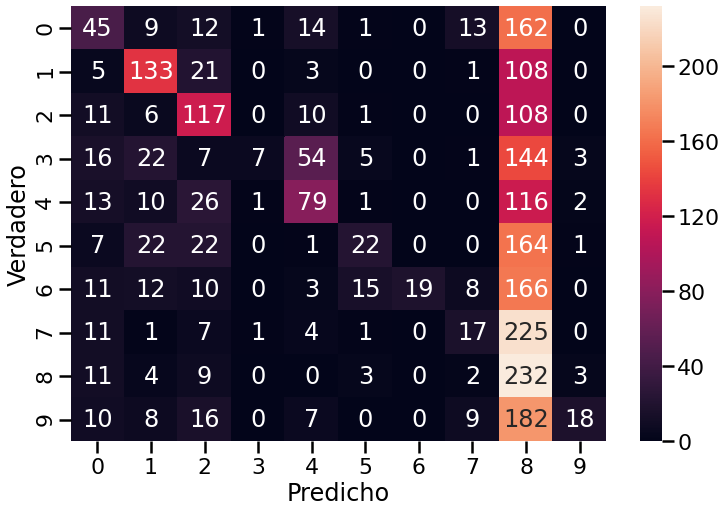

Clasification Report:
                precision    recall  f1-score   support

       eight       0.32      0.18      0.23       257
        five       0.59      0.49      0.53       271
        four       0.47      0.46      0.47       253
        nine       0.70      0.03      0.05       259
         one       0.45      0.32      0.37       248
       seven       0.45      0.09      0.15       239
         six       1.00      0.08      0.14       244
       three       0.33      0.06      0.11       267
         two       0.14      0.88      0.25       264
        zero       0.67      0.07      0.13       250

    accuracy                           0.27      2552
   macro avg       0.51      0.27      0.24      2552
weighted avg       0.51      0.27      0.25      2552

Mejor Modelo:  RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=12,
                       n_estimators=199)
Val Accuracy:  0.6960705693664796
Test Accuracy:  0.4482758620689655


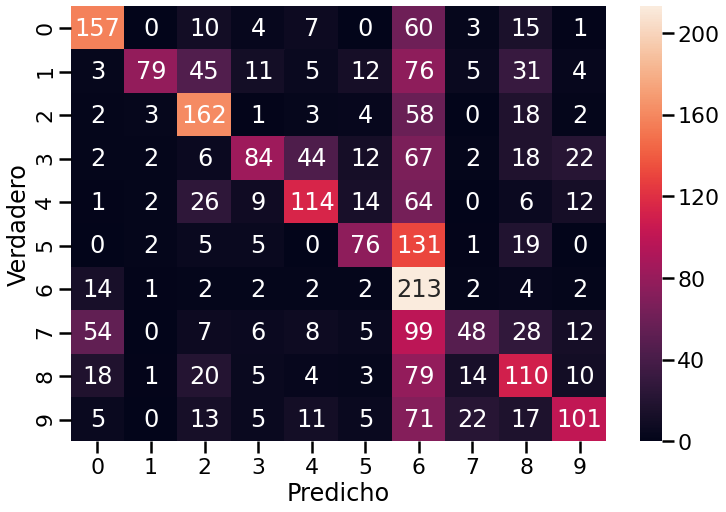

Clasification Report:
                precision    recall  f1-score   support

       eight       0.61      0.61      0.61       257
        five       0.88      0.29      0.44       271
        four       0.55      0.64      0.59       253
        nine       0.64      0.32      0.43       259
         one       0.58      0.46      0.51       248
       seven       0.57      0.32      0.41       239
         six       0.23      0.87      0.37       244
       three       0.49      0.18      0.26       267
         two       0.41      0.42      0.42       264
        zero       0.61      0.40      0.49       250

    accuracy                           0.45      2552
   macro avg       0.56      0.45      0.45      2552
weighted avg       0.56      0.45      0.45      2552

Mejor Modelo:  GradientBoostingClassifier(learning_rate=0.554, max_depth=6, n_estimators=195)
Val Accuracy:  0.7429831595829992
Test Accuracy:  0.49764890282131663


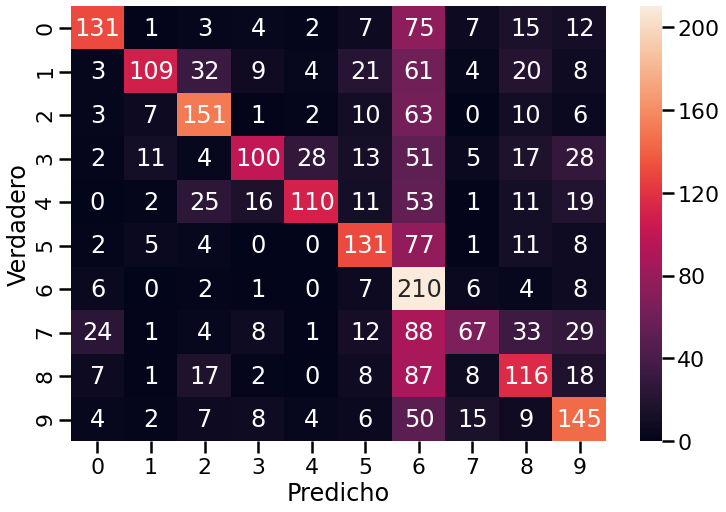

Clasification Report:
                precision    recall  f1-score   support

       eight       0.72      0.51      0.60       257
        five       0.78      0.40      0.53       271
        four       0.61      0.60      0.60       253
        nine       0.67      0.39      0.49       259
         one       0.73      0.44      0.55       248
       seven       0.58      0.55      0.56       239
         six       0.26      0.86      0.40       244
       three       0.59      0.25      0.35       267
         two       0.47      0.44      0.45       264
        zero       0.52      0.58      0.55       250

    accuracy                           0.50      2552
   macro avg       0.59      0.50      0.51      2552
weighted avg       0.59      0.50      0.51      2552



In [232]:
# Ploteamos las matrices de confusión y algunas métricas de los modelos
for i in all_models:
    print ("Mejor Modelo: ",i.best_estimator_)
    print ("Val Accuracy: ",i.best_score_)
    y_pred = i.predict(X_test)
    print ("Test Accuracy: ",accuracy_score(y_test, y_pred))
    plt.figure(figsize=(12,8))
    sns.set_context('poster')
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='g')
    plt.xlabel('Predicho')
    plt.ylabel('Verdadero')
    plt.show()
    print ("Clasification Report:\n ",classification_report(y_test,y_pred))

Conclusión: Notamos una enorme baja en el performance, el accuaracy baja de 0,74 a 0,49 en el set de evaluación. En cuanto a los errores, los modelos se confunden mucho prediciendo 6 para otros números. Debe estar confundiendo el sonido gaussiano con el 'sss' del 'six'

#####      ii) Audios de ruido ambiental.

In [153]:
ruidoaudio, sr = librosa.core.load('speechcommands/_background_noise_/doing_the_dishes.wav', sr=None)

In [154]:
ruidoaudio = ruidoaudio[5000:5000+len(audio)]

In [164]:
Audio(0.5*ruidoaudio + audio,rate=44100)

ValueError: rate must be specified when data is a numpy array or list of audio samples.

### g) Grabar audios pronunciando los dígitos en distintas condiciones ambientales. Por ejemplo, se puede probar grabando en distintos ambientes (baño vs. cocina), distintas distancias al micrófono, pronunciando de distintas maneras y utilizando distintos dispositivos (celular vs. laptop). Analizar los resultados y el efecto de las distintas condiciones sobre la performance de los modelos.